In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

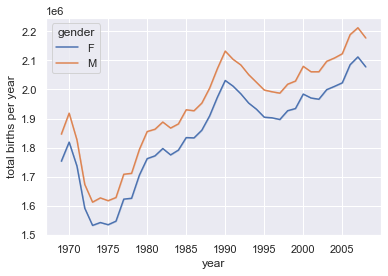

In [2]:
data = pd.read_csv('data/births.csv')

#Create a pd series of the total births per year
birth_ser = pd.Series(data.groupby(['year','gender'])['births'].sum())

#Merge DF and Ser on year and gender
data = pd.merge(data, birth_ser, on=['year','gender'])

#Rename new column to represent birth per year and revert origina
data = data.rename(columns = {'births_y':'total births per year', 'births_x':'births'})

#Set dark grid style
sns.set(style='darkgrid')

#Lineplot
sns.lineplot(x='year',y='total births per year',data=data,hue='gender')

plt.show()

In [3]:
##DIDN'T NEED TO DO THIS##

#Create a date col with month year. As DateTime. Assign day to be one. 
# bc some vals are NaN and might skew data. Let's just focus in month and year
#data['date'] = pd.to_datetime(data[['month', 'year']].assign(day=1))

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

## Answer:
### Relative Number of Births:
    -Looks at births by day of year and plots them to look at a yearly trend.  
    -Red line refers to the mean of births which is 100. 
    -Black line plots the births that happened each month of each year
    -Blue line plots a smooth version of actual births. I assume it is somewhat like a KDE which shows what a continuous probability function would look like for this particular dataset.
        
### Periodic component:
    -Seems to look at the parttern of births. The frequency in the births and looking at the differences that happens. So certain dates will have less births. ie. Holidays. Or more births 

### Residual: 
    -Residual plot looks at the differences in the actual births and redicted births. Outliers are shown in circle. So as we can see, certain days of the year have significantly less births than other days 

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

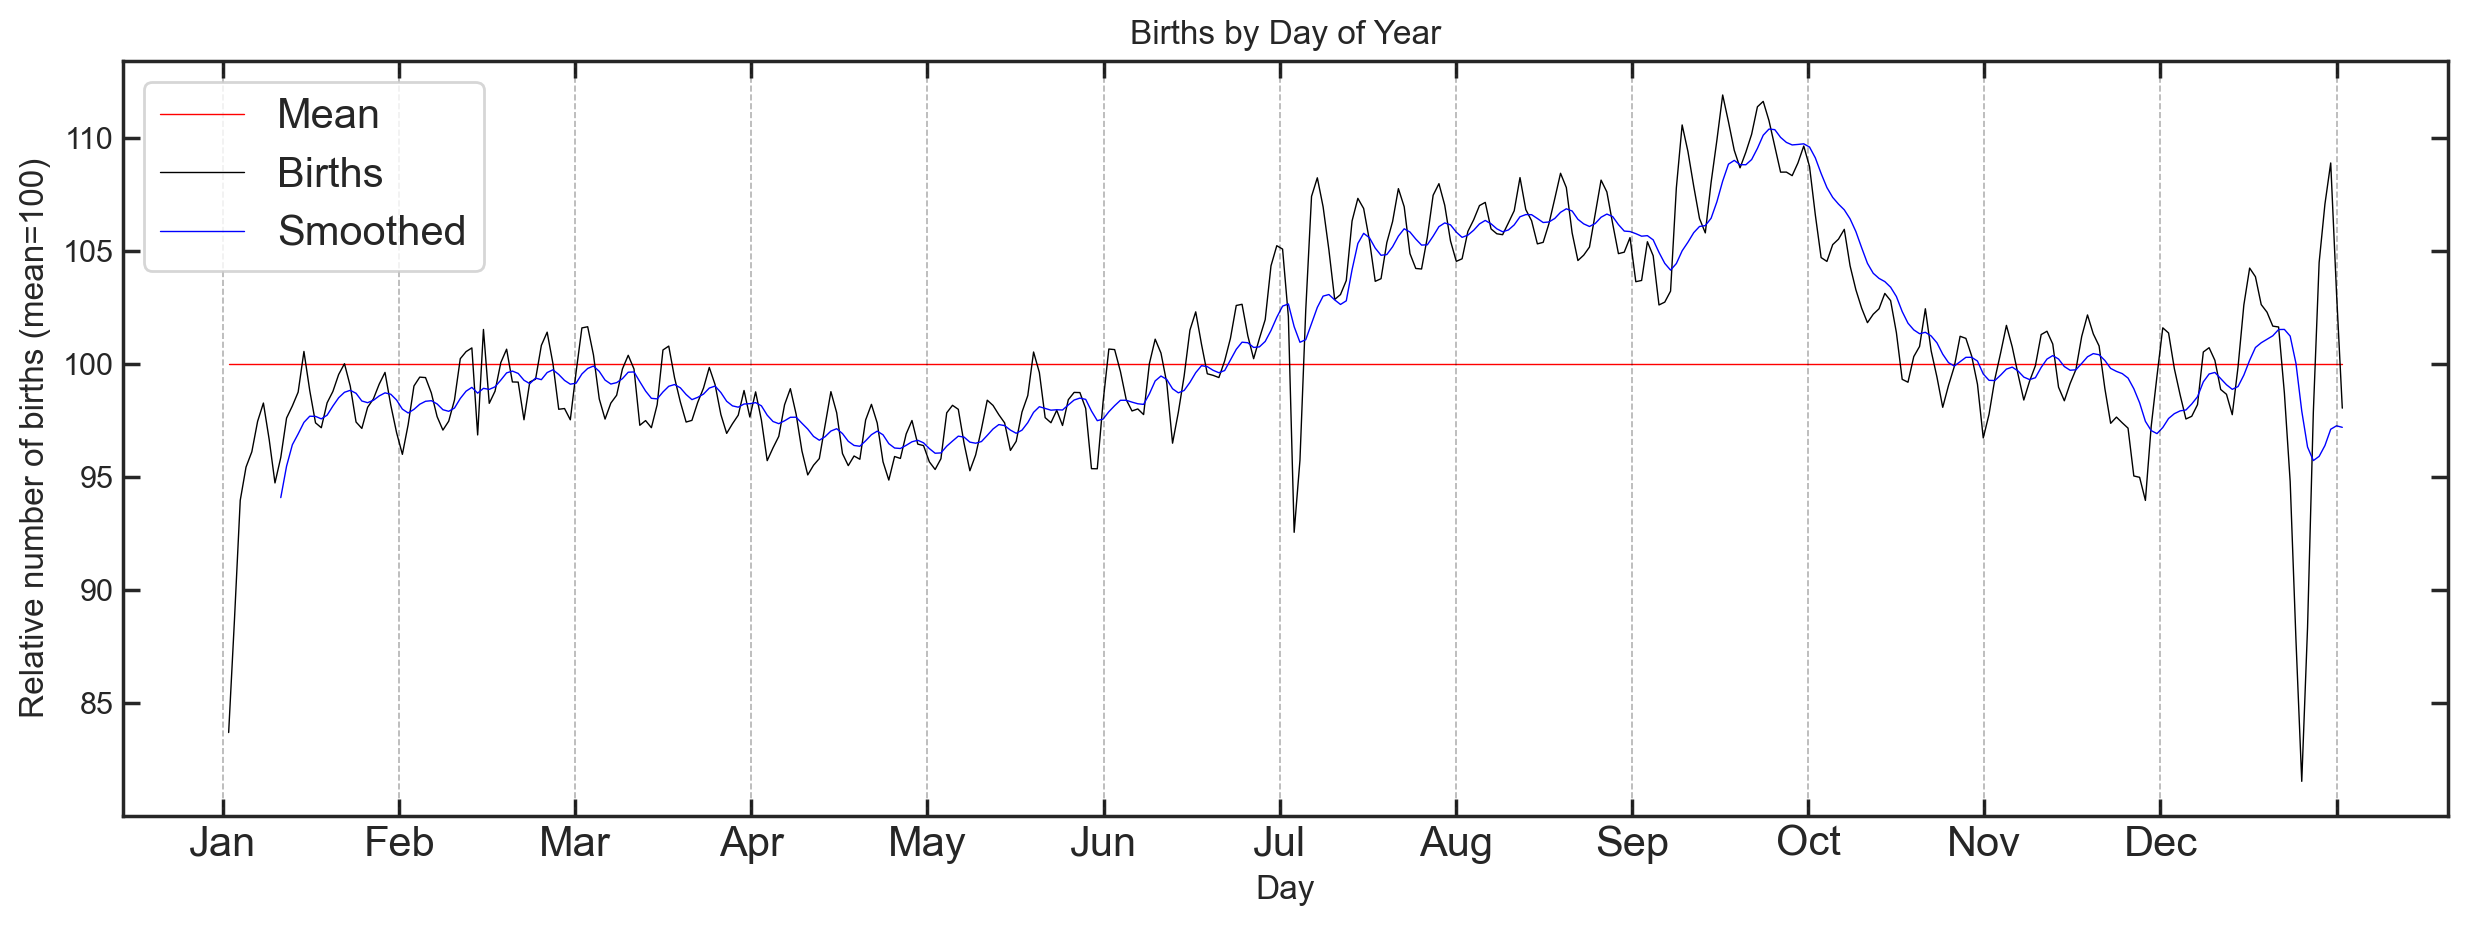

In [9]:
df = pd.read_csv('data/births.csv')

df = df.dropna() #Drop NaN values
df.day = df.day.astype(int) #convert to int
df = df.drop(df.index[df.day == 99]) #Drop nonsensical days

# Create a date column with datatime object. Coerce errors
df['date'] = pd.to_datetime(df[['year', 'month', 'day']] , errors='coerce')

#Set mean to 100. No calculations got me to 100...
df['mean'] = 100

#Get % of number of births on day compared to the DF average. 100% mean it is exactly at the mean. 
df['relative_births'] = df['births'] / df['births'].mean() * 100

#Converts specific day to a numeric value. Jan 1 of any year is 1
df['day number'] = df.date.dt.dayofyear 

#Groupby numeric day and get the mean of the mean
mean = df.groupby('day number')['mean'].mean() #if we just set mean to 100 skews data/error

#Group by day number to get the average relative_births for specific day for all years. This is black line
births = df.groupby('day number')['relative_births'].mean()

#Rolling window which looks at previous births and gives us the smooth line
rolling = births.rolling(window=10).mean() #Want to look at rolling for births not mean. 

#Plot
sns.set(style='white')
fig, ax = plt.subplots(figsize = (15,5),dpi=200)

#Lines
mean.plot(color='red',lw=.5, label='Mean')
births.plot(color='black',lw=.5, label='Births')
rolling.plot(color='blue',lw=.5, label='Smoothed')

#Formatting
plt.xticks(np.linspace(0,365,13), #use linspace not arange & set ticks to months manually
           ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'),size=15)

plt.legend(loc=2,fontsize=15) #Int value for upper-left and set fontsize
plt.title('Births by Day of Year')
plt.xlabel('Day')
plt.ylabel('Relative number of births (mean=100)')

#Sets ticks around the graph. Direction decides whether inward or outward
ax.tick_params(direction='in',right=True,left=True,top=True,bottom=True)

#https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.axes.Axes.axvline.html
## Dotted lines top-bottom of graph
ticks = np.linspace(0,365,13) #Match up with ticks above
for t in ticks :
    plt.axvline(x=t,lw=.6,color='black',ls='--', alpha=0.3)

plt.show()

<ipython-input-10-b5c09e6b66ea>:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df_piv.index = [pd.datetime(2012, month, day) for (month, day) in df_piv.index] #lst comprehension


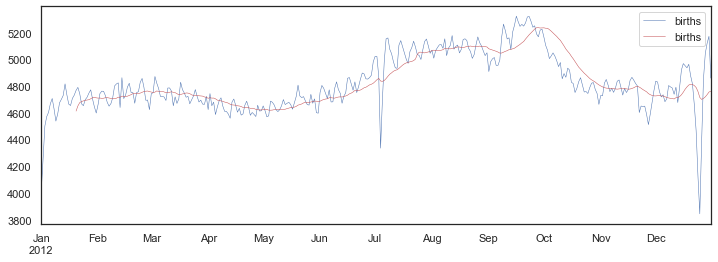

In [10]:
#Second attempt

df = pd.read_csv('data/births.csv')


quartiles = np.percentile(df.births,[25,50,75])

mu = quartiles[1]

sig = 0.74 * (quartiles[2] - quartiles[0])

df = df.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

df['day'] = df['day'].astype(int)
df['mean'] = 100

df.index = pd.to_datetime(10000 * df['year'] +
                          100 * df['month'] +
                          df['day'],
                         format='%Y%m%d')

df_piv = df.pivot_table('births', [df.index.month, df.index.day])

#df.groupby([df.index.month, df.index.day]).agg(np.mean), df_2

df_piv.index = [pd.datetime(2012, month, day) for (month, day) in df_piv.index] #lst comprehension

#Plot 
fig, ax = plt.subplots(figsize=(12, 4))
#plt.xlim((-2,1))
df_piv.plot(ax=ax, lw=.5)
#df_piv.plot(df_piv.mean)

df_piv.rolling(window=20).mean().plot(color='r', ax=ax, lw=.5)

plt.show()

In [11]:
#Create a date col with month year. As DateTime. Assign day to be one. 
# bc some vals are NaN and might skew data. Let's just focus in month and year
#data['date'] = pd.to_datetime(data[['month', 'year']].assign(day=1))

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [12]:
import gzip
import json
#Read entire file into Python array
with gzip.open('data/recipe.json.gz', 'r') as f:
    #Extract each line
    data = (line.strip().decode() for line in f)
    #Reformat so each line is the element of that list
    data_json = f"[{','.join(data)}]"
#read the results as a Json
recipes = pd.read_json(data_json)

In [13]:
recipes['description'].str.lower().str.contains("breakfast").sum()
#Need to set case to lower (or upper) so all case is the same. Search specific column and sum the total

3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [14]:
def recommend_ingredients(ingredients, data):
    """
    Takes a basic ingredient list and returns a recipe
    that uses all those ingredients
    """
    
    ing_list = ['salt', 'pepper', 'oregano', 'sage', 'parsley','rosemary',
                'tarragon', 'thyme', 'paprika', 'cumin']
    
    for ing in ing_list:
        data[ing] = data['ingredients'].str.lower().str.contains(ing) #Bool col of if ing in recipe
        #New col for each ingredients telling us whether present or not
        
    for ingredient in ingredients:
        data = data[data[ingredient] == True] #Return rows where ings are True
    
    return data.index #Return index of recipes with all ingredients


ingredients = ['parsley', 'paprika', 'tarragon']

data = recipes 

recommend_ingredients(ingredients,data)

#Not sure how to differentiate between Paprika and SMOKED paprika. Thus why I have more recipes (I assume)

Int64Index([  2069,  74964,  93768, 113926, 137686, 140530, 158475, 158486,
            162896, 163175, 165243, 171774],
           dtype='int64')


# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [15]:
movies_url = {
"movies_metadata": "1RLvh6rhzYiDDjPaudDgyS9LmqjbKH-wh",
"keywords": "1YLOIxb-EPC_7QpkmRqkq9E6j7iqmoEh3",
"ratings": "1_5HNurSOMnU0JIcXBJ5mv1NaXCx9oCVG",
"credits": "1bX9othXfLu5NZbVZtIPGV5Hbn8b5URPf",
"ratings_small": "1fCWT69efrj4Oxdm8ZNoTeSahCOy6_u6w",
"links_small": "1fh6pS7XuNgnZk2J3EmYk_9jO_Au_6C15",
"links": "1hWUSMo_GwkfmhehKqs8Rs6mWIauklkbP",
}

def read_gdrive(url):
    """
    Reads file from Google Drive sharing link
    """
    path = 'https://drive.google.com/uc?export=download&id='+url
    return pd.read_csv(path)

In [16]:
metadata = pd.read_csv('data/archive/movies_metadata.csv')
credits = pd.read_csv('data/archive/credits.csv')
ratings_small = pd.read_csv('data/archive/ratings_small.csv')
ratings = pd.read_csv('data/archive/ratings.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
N_VOTES = 1000 #Number of votes
N_FILMS = 30   #Number of films directed

def director_find(data):
    """Returns name of director from crew data"""
    for crew in eval(data):
        if crew['job'] == 'Director':
            return crew['name']
        
#Apply function to find director and add a new column to credits
credits['director'] = credits.crew.apply(director_find)

#Convert credits id as str to prevent merging erros
credits['id'] = credits['id'].astype(str)

#Merge credits and metadata on id. New df shows director at the end
meta_credits = pd.merge(metadata, credits, on=['id'])

#meta_ = meta_credits[['id', 'title', 'director', 'vote_average','vote_count']] #if I wanted a DF with selected rows

#Calculate the number of films each director has done and change col title
num_film_df = pd.DataFrame(meta_credits['director'].value_counts())
num_film_df = num_film_df.rename(columns = {'director':'num_of_film'})

#Merdge num of film made to meta_credits
meta_credits = pd.merge(meta_credits, num_film_df, left_on='director', right_index=True)

#Look at movies which had at least 1000 votes and did at least 30 films
meta_ = meta_credits[(meta_credits['vote_count'] >= N_VOTES) & (meta_credits['num_of_film'] >= N_FILMS)]

#Group by director and get the average of their vote_average for each film. returns top 10
pd.DataFrame(meta_.groupby('director')['vote_average'].mean().sort_values(ascending=False).head(10))

,vote_average
director,
Sidney Lumet,8.200000
Alfred Hitchcock,8.075000
Frank Capra,8.000000
Michael Curtiz,7.900000
Martin Scorsese,7.644444
Blake Edwards,7.600000
Clint Eastwood,7.437500
Spike Lee,7.300000
Woody Allen,7.220000


In [273]:
meta_ = meta_credits.groupby('director')[['vote_average']].mean().reset_index() 
#Double [[]] creates a DF

In [274]:
meta_

,director,vote_average
0,Dale Trevillion\t,2.0
1,Davide Manuli,6.9
2,E.W. Swackhamer,5.9
3,Vitaliy Vorobyov,5.5
4,Yeon Sang-Ho,6.6
...,...,...
17567,Ярополк Лапшин,10.0
17568,پیمان معادی,6.0
17569,塩谷 直義,7.2
17570,杰森·莫玛,5.8
